# California House Prices

What's the end goal? Be able to predict median house prices in Californian districts based on a set of attributes (features).

Probably want to use a Regression model, with batch learning (no need to be streaming data in) and we can use the RMSE as our performance measure.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

Load data

In [3]:
HOUSING_DATA_PATH = Path("/home/jaf/Work/projects/hands_on_ml/handson-machine-learning-projects/datasets/housing") / "housing.csv"

In [4]:
def load_data(data_filepath):
    return pd.read_csv(data_filepath)

In [5]:
housing_data = load_data(HOUSING_DATA_PATH)
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Ocean Proximity looks like it's categorical data so let us check how many categories actually exist

In [8]:
housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's have a look at what's going on

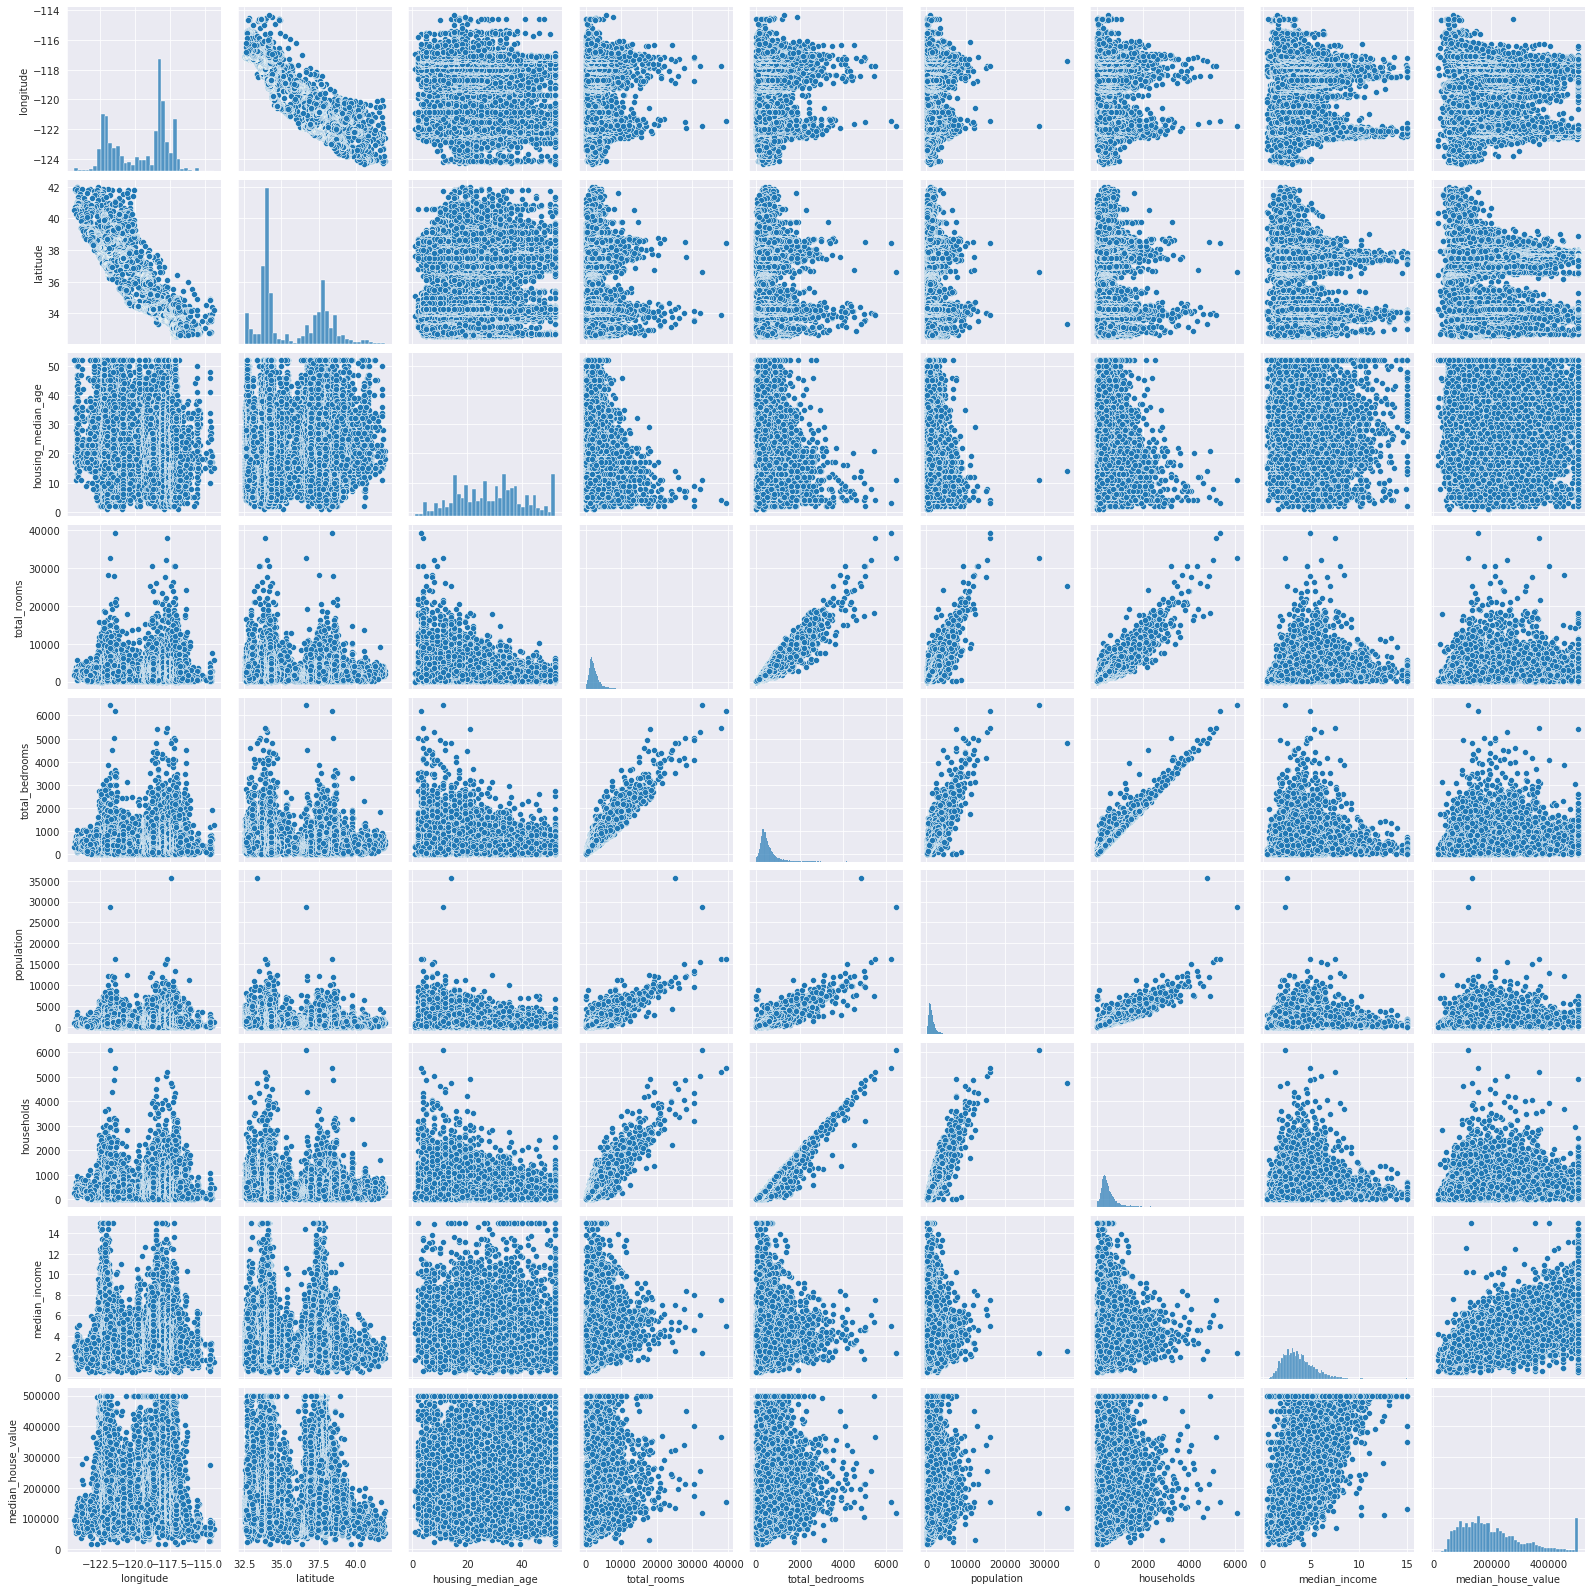

In [9]:
sns.pairplot(housing_data)

Experts mention that median income is very important for predicting house prices. So we should have a representative sample in both test and train data. Median income is a continous variable so we need to categorise it so we can use it. 

In [10]:
housing_data["income_cat"] = pd.cut(
    housing_data["median_income"], 
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
    )

<AxesSubplot:>

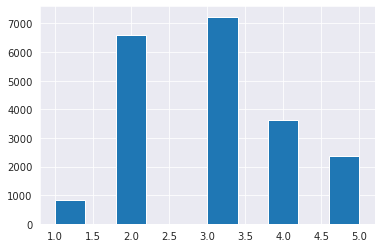

In [11]:
housing_data.income_cat.hist()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

to see if it worked, let's check the proportions

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [14]:
housing_data["income_cat"].value_counts() / len(housing_data)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

`income_cat` has now served it's purpose so it can go

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

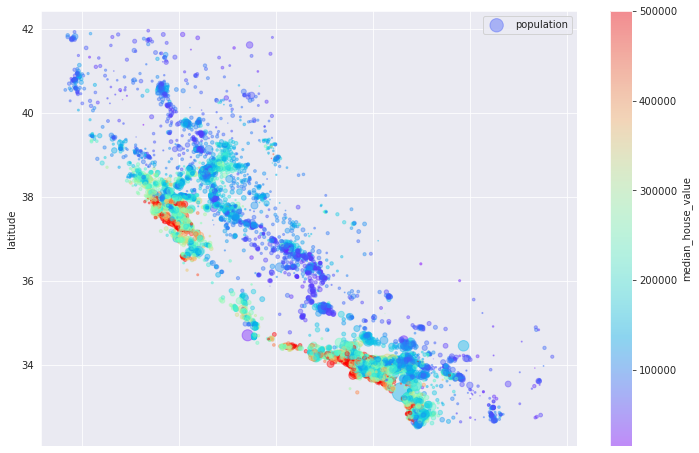

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(12,8),
    c="median_house_value", cmap=plt.get_cmap("rainbow"), colorbar=True,
)

let's get some standard correlation stats

In [18]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

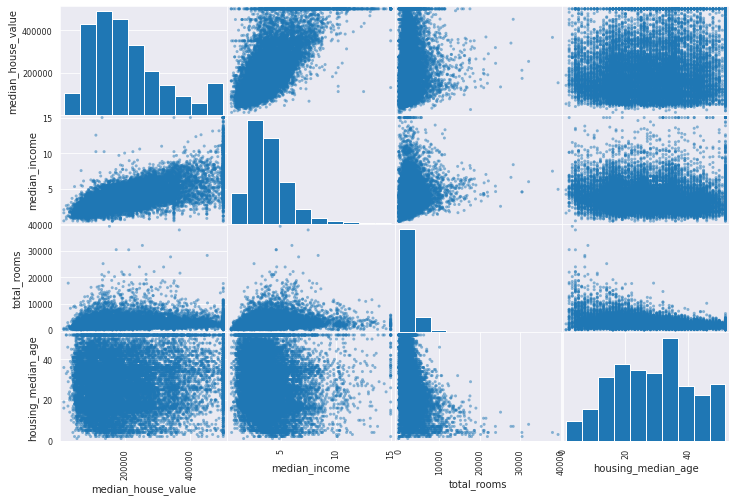

In [19]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

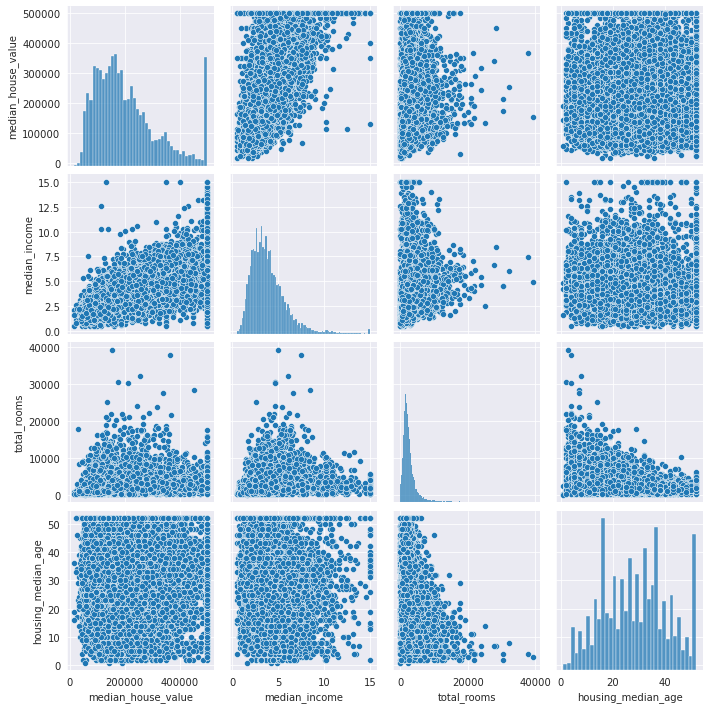

In [28]:
sns.pairplot(housing[attributes])

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

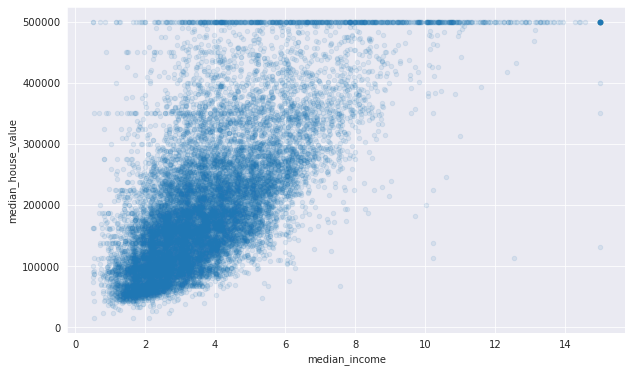

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10,6))

the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

New `bedrooms_per_room` is a good attribute with decent negative correlation which makes sense as the lower the ratio the bigger the house and therefore more expensive

### Cleaning the data

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Possible solutions for dealing with missing data

housing.dropna(subset=["total_bedrooms"])    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3

housing["total_bedrooms"].fillna(median, inplace=True)


If you choose option 3, you should compute the median value on the training set and use it to fill the missing values in the training set. Don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [32]:
housing_numeric = housing.drop("ocean_proximity", axis=1)

In [37]:
X = imputer.fit_transform(housing_numeric)

In [34]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [36]:
housing_numeric.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [38]:
housing_transformed = pd.DataFrame(X, columns=housing_numeric.columns, index=housing_numeric.index)

In [41]:
housing_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [43]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [45]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [47]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [48]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom attribute adder

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

In [52]:
class CombinedAttributesAdders(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, room_indx] / X[:, households_indx]
        population_per_household = X[:, population_indx] / X[:, households_indx]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_indx] / X[:, room_indx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


room_indx, bedrooms_indx, population_indx, households_indx = 3, 4, 5, 6

attr_adder = CombinedAttributesAdders(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [54]:
housing_extra_attribs[:3]

array([[-121.46, 38.52, 29.0, 3873.0, 797.0, 2237.0, 706.0, 2.1736,
        'INLAND', 5.485835694050992, 3.168555240793201],
       [-117.23, 33.09, 7.0, 5320.0, 855.0, 2015.0, 768.0, 6.3373,
        'NEAR OCEAN', 6.927083333333333, 2.6236979166666665],
       [-119.04, 35.37, 44.0, 1618.0, 310.0, 667.0, 300.0, 2.875,
        'INLAND', 5.3933333333333335, 2.223333333333333]], dtype=object)

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1.

Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization.

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdders()),
    ("std_scaler", StandardScaler()),
])

housing_numeric_transformed = num_pipeline.fit_transform(housing_numeric)

In [57]:
housing_numeric_transformed[1]

array([ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
        0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
       -0.81086696])

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_numeric)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [61]:
housing_prepared[0]

array([-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
        0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
       -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ])

In [62]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


## Select and Train a model

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [65]:
# Testing on a few training data instances

some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {lin_reg.predict(some_data_prepared)}.")

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089].


In [66]:
print(f"Labels: {list(some_labels)}")

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


not super accurate init

Text(0.5, 0, 'index')

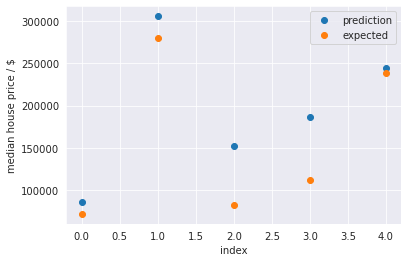

In [72]:
plt.plot(lin_reg.predict(some_data_prepared),'o',label="prediction")
plt.plot(list(some_labels),'o',label="expected")
plt.legend()
plt.ylabel("median house price / $")
plt.xlabel("index")

In [73]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

This is better than nothing, but clearly not a great score: most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.

In [74]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [75]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

#### Using Cross validation

In [76]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [77]:
tree_rmse_scores

array([71499.06366269, 69856.38617297, 69344.2480127 , 70669.92949529,
       70179.88340632, 75442.30043568, 72150.88017676, 74073.14289051,
       68153.42856285, 71172.013884  ])

In [78]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [79]:
display_scores(tree_rmse_scores)

Scores: [71499.06366269 69856.38617297 69344.2480127  70669.92949529
 70179.88340632 75442.30043568 72150.88017676 74073.14289051
 68153.42856285 71172.013884  ]
Mean: 71254.12766997742
Standard deviation: 2075.3188694204823


In [80]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

In [81]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [83]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
forest_rmse


18610.91866446401

In [84]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51458.80327206 48933.96263099 46656.35983342 52145.86275285
 47324.9990639  52549.48816539 52390.97696773 50250.10665322
 48313.82841817 53628.44135746]
Mean: 50365.28291151939
Standard deviation: 2305.612467903983


In [85]:
def save_ml_model(model, model_filepath):
    import joblib
    
    joblib.dump(model, model_filepath)

In [86]:
from sklearn.linear_model import BayesianRidge

bayes_reg = BayesianRidge()
bayes_reg.fit(housing_prepared, housing_labels)
housing_predictions = bayes_reg.predict(housing_prepared)
bayes_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
print(f"Bayes RMSE: {bayes_rmse}")

bayes_scores = cross_val_score(bayes_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
bayes_rmse_scores = np.sqrt(-bayes_scores)
display_scores(bayes_rmse_scores)

Bayes RMSE: 68633.46999050754
Scores: [71734.56400022 64208.56701351 67741.16655672 68644.48484399
 66841.42201314 72527.21022287 73982.540925   68803.94245285
 66448.92879138 70143.75573691]
Mean: 69107.65825565986
Standard deviation: 2860.275948385811


In [87]:
from sklearn.svm import LinearSVR

lsvm_reg = LinearSVR()
lsvm_reg.fit(housing_prepared, housing_labels)
housing_predictions = lsvm_reg.predict(housing_prepared)
lsvm_reg_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
print(f"Linear SVM RMSE: {lsvm_reg_rmse}")

lsvm_scores = cross_val_score(lsvm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lsvm_rmse_scores = np.sqrt(-lsvm_scores)
display_scores(lsvm_rmse_scores)

Linear SVM RMSE: 218350.0174075901
Scores: [217175.72549406 224521.9620495  212148.72370351 222495.87239957
 214562.88463364 225734.96542686 222340.54471311 220301.24481705
 222668.84534859 219784.30785366]
Mean: 220173.50764395582
Standard deviation: 4137.459912804905


In [89]:
from sklearn.svm import NuSVR

nsvm_reg = NuSVR()
nsvm_reg.fit(housing_prepared, housing_labels)
housing_predictions = nsvm_reg.predict(housing_prepared)
nsvm_reg_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
print(f"NuSVM RMSE: {nsvm_reg_rmse}")

nsvm_scores = cross_val_score(nsvm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
nsvm_rmse_scores = np.sqrt(-nsvm_scores)
display_scores(nsvm_rmse_scores)

NuSVM RMSE: 116391.36079197339
Scores: [114744.62931574 117425.36924208 112618.99694312 118104.43878664
 112988.87263686 120093.84252974 117490.5375847  116036.3145
 117837.85664021 116771.26429916]
Mean: 116411.21224782537
Standard deviation: 2231.558726981794


### Fine Tuning

In [91]:
((98/10)*90)/60

14.700000000000001

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [93]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [94]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30)

In [95]:
cvres = grid_search.cv_results_

In [96]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64096.64120154611 {'max_features': 2, 'n_estimators': 3}
55995.65741067487 {'max_features': 2, 'n_estimators': 10}
52619.57892108542 {'max_features': 2, 'n_estimators': 30}
60237.239600118904 {'max_features': 4, 'n_estimators': 3}
52923.322083709405 {'max_features': 4, 'n_estimators': 10}
49990.925230436915 {'max_features': 4, 'n_estimators': 30}
59396.061041972265 {'max_features': 6, 'n_estimators': 3}
51974.99567073571 {'max_features': 6, 'n_estimators': 10}
50147.08407939366 {'max_features': 6, 'n_estimators': 30}
59242.986522661384 {'max_features': 8, 'n_estimators': 3}
52240.77740732492 {'max_features': 8, 'n_estimators': 10}
50023.293882502 {'max_features': 8, 'n_estimators': 30}
62278.60159745493 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54158.20068349116 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59354.253743095214 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52720.306109702506 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [98]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.54042826e-02, 7.74940266e-02, 4.13777500e-02, 2.57386133e-02,
       1.99554941e-02, 2.48069418e-02, 2.08746163e-02, 2.95207099e-01,
       5.85801405e-02, 9.26666037e-02, 9.27679284e-02, 2.47162071e-02,
       1.17995178e-01, 4.71031282e-05, 9.88106361e-03, 1.24869516e-02])

In [101]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.29520709900920816, 'median_income'),
 (0.11799517819073287, 'INLAND'),
 (0.0927679284241073, 'bedrooms_per_room'),
 (0.09266660374536496, 'pop_per_hhold'),
 (0.08540428264759484, 'longitude'),
 (0.07749402658779198, 'latitude'),
 (0.058580140532256846, 'rooms_per_hhold'),
 (0.04137775004420195, 'housing_median_age'),
 (0.025738613283432795, 'total_rooms'),
 (0.024806941761032347, 'population'),
 (0.024716207107217853, '<1H OCEAN'),
 (0.020874616259854557, 'households'),
 (0.019955494104132342, 'total_bedrooms'),
 (0.012486951568632339, 'NEAR OCEAN'),
 (0.009881063606234067, 'NEAR BAY'),
 (4.710312820482421e-05, 'ISLAND')]

### Evaluate model on test set


There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()—you do not want to fit the test set!), and evaluate the final model on the test set:

In [102]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

48354.89017042639

if we don't just want a point estimate, we can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval()

In [103]:
from scipy import stats

confidence = .95

squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46407.53673048, 50226.79903595])

If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “the median income is the number one predictor of housing prices”). In this California housing example, the final performance of the system is not better than the experts’ price estimates, which were often off by about 20%, but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.